In [ ]:
import pandas as pd
import sys
sys.path.append("..")  # Use sys to add the parent directory (where hex_maze_utils lives) to the path

from hex_maze_utils import plot_hex_maze, maze_to_graph, maze_to_barrier_set

# Load the maze configuration database
maze_database = pd.read_pickle('../Maze_Databases/maze_configuration_database.pkl')
print(f"Here's our database of {len(maze_database)} hex mazes:")
display(maze_database.head())


Here's our database of 55896 hex mazes:


,barriers,len12,len13,len23,reward_path_lengths,path_length_difference,optimal_paths_12,optimal_paths_13,optimal_paths_23,optimal_paths_all,choice_points,num_choice_points,cycles,num_cycles,isomorphic_mazes
0,"(37, 39, 7, 41, 14, 46, 20, 23, 30)",15,17,21,"[15, 17, 21]",6,"[[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, ...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 1...","[[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, ...",{13},1,[],0,"{(37, 8, 9, 40, 20, 21, 22, 27, 28), (34, 8, 4..."
1,"(34, 36, 37, 39, 10, 45, 14, 15, 20)",17,21,19,"[17, 21, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 25, 30, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 25, 30, 35, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{21},1,[],0,"{(34, 37, 8, 40, 10, 15, 18, 20, 26), (34, 35,..."
2,"(34, 7, 41, 11, 46, 17, 20, 28, 31)",23,19,17,"[23, 19, 17]",6,"[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 25, 30, 35, 4...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...",{35},1,"[[38, 49, 47, 42, 37, 32]]",1,"{(35, 7, 10, 44, 20, 22, 27, 28, 31), (32, 37,..."
3,"(34, 10, 42, 12, 45, 18, 23, 25, 31)",15,19,21,"[15, 19, 21]",6,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 22, 27, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 22, 27, 32, ...",{17},1,[],0,"{(34, 37, 8, 40, 13, 46, 15, 18, 25), (34, 37,..."
4,"(39, 9, 10, 46, 21, 22, 23, 26, 30)",23,17,17,"[23, 17, 17]",6,"[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 2...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...",{29},1,"[[32, 38, 49, 47, 42, 37], [12, 15, 19, 24, 20...",2,"{(34, 36, 8, 41, 9, 21, 23, 27, 30), (10, 11, ..."


In [ ]:
import networkx as nx

# Work on some functions to define dead end paths. This gets weird for paths that are not linear dead ends

def find_non_dead_end_hexes(maze) -> set[int]:
    """
    Finds all hexes on any paths between reward port hexes 1, 2, and 3.
    Includes all paths between ports (not limited to optimal paths).
    Every other hex is part of a dead end.

    Parameters:
        maze (list, set, frozenset, np.ndarray, str, nx.Graph):
            The hex maze represented in any valid format

    Returns:
        set: Set of all hexes on paths between reward ports
    """
    # Convert all valid maze representations to a nx.Graph object
    graph = maze_to_graph(maze)

    non_dead_end_hexes = set()
    for port_hex_pair in [(1, 2), (2, 3), (1, 3)]:
        # Get all possible paths between this pair of reward ports
        all_paths_between_ports = nx.all_simple_paths(graph, port_hex_pair[0], port_hex_pair[1])
        # For each path, add all hexes on the path to our set of non dead end hexes
        non_dead_end_hexes.update(hex for path in all_paths_between_ports for hex in path)

    return non_dead_end_hexes


def distance_to_nearest_hex_in_group(maze, hexes, target_group) -> int | dict:
    """
    Calculate the distance (in hexes) between each hexes in 'hexes' and
    the nearest hex in the target group. Often used to calculate how far into
    a dead end a given hex is.

    Parameters:
        maze (list, set, frozenset, np.ndarray, str, nx.Graph):
            The hex maze represented in any valid format
        hexes (int | list | set): Hex(es) to calculate distance for
        target_group (set): The group of hexes to compute distance to

    Returns:
        int or dict: Shortest distance to any hex in target_group 
            (int if a single hex was passed, or a dict for multiple hexes)
    """
    # Convert all valid maze representations to a nx.Graph object
    graph = maze_to_graph(maze)

    # Make hexes iterable so this works with a single hex too
    single_hex = not isinstance(hexes, (list, set, tuple))
    hexes = [hexes] if single_hex else hexes

    distances = {}
    for hex in hexes:
        # Find the shortest path lengths from this hex to all hexes in the maze
        path_lengths = nx.single_source_shortest_path_length(graph, hex)
        # Filter for only paths from the hex to hexes in the target_group
        valid_lengths = [dist for target_hex, dist in path_lengths.items() if target_hex in target_group]
        # Get the min distance from this hex to any hes in the target group
        distances[hex] = min(valid_lengths, default=float('inf'))
    # Return an int if only one hex, or a dict if multiple
    return next(iter(distances.values())) if single_hex else distances


def find_dead_end_paths(maze) -> list[list]:
    # Convert all valid maze representations to a nx.Graph object
    graph = maze_to_graph(maze)

    # Find all hexes that are not part of dead ends
    non_dead_end_hexes = find_non_dead_end_hexes(graph)

    # Get a subgraph of the maze including only hexes that are a part of dead ends
    dead_end_subgraph = graph.subgraph(node for node in graph.nodes if node not in non_dead_end_hexes)

    # Each connected component is a group of dead end hexes
    dead_end_groups_unsorted = [list(maze_component) for maze_component in nx.connected_components(dead_end_subgraph)]

    dead_end_groups = []
    dead_end_hex_distances = []
    # For each dead end group, get how far into the dead end each hex is
    for group in dead_end_groups_unsorted:
        # Get a dict of hex: how far into the dead end it is
        distances = distance_to_nearest_hex_in_group(graph, group, non_dead_end_hexes)
        # Sort the dead end group by distance (closest to maze first)
        dead_end_groups.append(sorted(group, key=lambda hex: distances[hex]))
        dead_end_hex_distances.append(distances)

    return dead_end_groups, dead_end_hex_distances


{37, 7, 39, 41, 14, 46, 20, 23, 30}


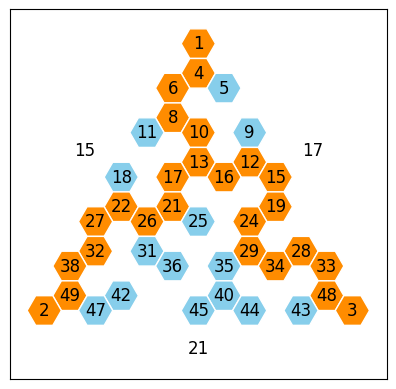

[[35, 40, 44, 45], [31, 36], [5], [9], [47, 42], [11], [43], [18], [25]]
[{40: 2, 35: 1, 44: 3, 45: 3}, {36: 2, 31: 1}, {5: 1}, {9: 1}, {42: 2, 47: 1}, {11: 1}, {43: 1}, {18: 1}, {25: 1}]


In [84]:
# Grab the first maze from the database
# interesting ones = 0, 6, 7, 10, 11
example_maze = maze_to_barrier_set(maze_database.iloc[0]['barriers'])
print(example_maze)

main_graph = find_non_dead_end_hexes(example_maze)
plot_hex_maze(example_maze, highlight_hexes=main_graph, show_barriers=False)

dead_end_groups, dead_end_hex_distances = find_dead_end_paths(example_maze)

print(dead_end_groups)
print(dead_end_hex_distances)